1
2
Extracting Data of Class: Walk
Extracting Data of Class: Run
Epoch 1/2
19/19 [==============================] - 14s 395ms/step - loss: 0.6444 - accuracy: 0.6803 - val_loss: 0.5746 - val_accuracy: 0.7487
Epoch 2/2
7/7 [==============================] - 1s 83ms/step - loss: 0.5862 - accuracy: 0.7487
Test Accuracy: 0.7487179636955261


c:\Users\saayo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


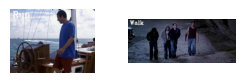

In [4]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import *
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Set seed for reproducibility
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

#all of the contents in the path
classes_names = os.listdir("E:/Projects/Baby/Media/Dataset")

#iterating over the classes
for counter, index in enumerate(classes_names, 1):
    selected_class_name = index 
    video_files_names_list = os.listdir(f'E:/Projects/Baby/Media/Dataset/{selected_class_name}')
    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'E:/Projects/Baby/Media/Dataset/{selected_class_name}/{selected_video_file_name}')
    # print(video_reader.isOpened())

    success, bgr_frame = video_reader.read()
    # print(success)
    # print(bgr_frame)
    
    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)
    print(counter)
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')


img_ht, img_width = 64, 64
seq_length = 20
dataset = 'E:/Projects/Baby/Media/Dataset'

classes = ["Walk", "Run"]

# Function to extract frames from video
def frames_extraction(path):
    frames_list = []
    video_reader = cv2.VideoCapture(path)

    for frame_counter in range(seq_length):
        success, frame = video_reader.read() 
        if not success:
            break
        resized_frame = cv2.resize(frame, (img_ht, img_width))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    
    video_reader.release()
    return frames_list

# Function to create dataset
def create_dataset():
    features = []
    labels = []
    label_encoder = LabelEncoder()
    for class_name in classes:
        print(f'Extracting Data of Class: {class_name}')
        file_list = os.listdir(os.path.join(dataset, class_name))
        for file_name in file_list:
            video_file_path = os.path.join(dataset, class_name, file_name)
            frames = frames_extraction(video_file_path)
            features.append(frames)
            labels.append(class_name)
    features = np.asarray(features)
    # Encode string labels to integers
    labels = label_encoder.fit_transform(labels)
    return features, labels

features, labels = create_dataset()

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, 
                                                                            test_size=0.25, shuffle=True, 
                                                                            random_state=seed_constant) 

# Reshape data for LSTM input (samples, time_steps, features)
features_train = features_train.reshape(features_train.shape[0], seq_length, img_ht * img_width * 3)
features_test = features_test.reshape(features_test.shape[0], seq_length, img_ht * img_width * 3)

# Create LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(seq_length, img_ht * img_width * 3)))
    model.add(Dropout(0.2))
    model.add(LSTM(128))  
    model.add(Dense(1, activation="sigmoid"))  
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  #It is an adaptive method for learning rate adjustment strategy and also includes better momentum than other optimizers.
    return model

# Construct the LSTM model
lstm_model = create_lstm_model()

# len(np.unique(labels))
# Train the model
lstm_model.fit(features_train, labels_train, validation_data=(features_test, labels_test), epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = lstm_model.evaluate(features_test, labels_test) 
print(f'Test Accuracy: {accuracy}')

# Save the model
lstm_model.save('LSTM_Model.h5')
